In [ ]:
from typing import Annotated, List
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
LANGSMITH_API_KEY=os.getenv("LANGSMITH_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"]= GROQ_API_KEY
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY
os.environ["LANGSMITH_TRACING"]="true"
os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"

#### Create Tools

**ResearchTeam tools:**
The research team can use a search engine and url scraper to find information on the web. Feel free to add additional functionality below to boost the team performance!

In [5]:
tavaily_tool=TavilySearchResults(max_results=5)

In [6]:
@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

**Document writing team tools**:
Next up, we will give some tools for the doc writing team to use. We define some bare-bones file-access tools below.

In [9]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


In [10]:
@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])

In [11]:
@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


In [12]:
@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()

In [13]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

* Create a worker agent.
* Create a supervisor for the sub-graph.

In [14]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.messages import HumanMessage, trim_messages

class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

#### Define Agent Teams
**Research Team**

In [16]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [18]:
search_agent = create_react_agent(llm, tools=[tavaily_tool])

In [19]:
llm.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_54eb4bd693', 'id': 'chatcmpl-BYX83qtpB3EPsAYuD90I9BTVpfuYz', 'finish_reason': 'stop', 'logprobs': None}, id='run-52827125-5749-4eb5-b6e4-f7421fd32f09-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [20]:
def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

In [21]:
web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])

In [22]:
def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

In [23]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

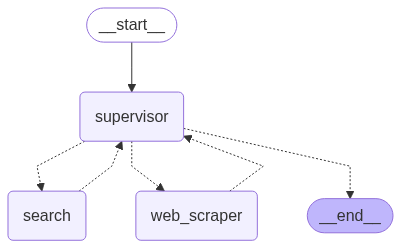

In [ ]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [26]:
for s in research_graph.stream(
    {"messages": [("user", "Feature of Akash Missile?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content="The Akash Missile is an advanced surface-to-air missile system developed by India's Defence Research and Development Organisation (DRDO). Here are some key features of the Akash Missile:\n\n1. **Specifications**:\n   - **Length**: Approximately 5.8 meters\n   - **Diameter**: 350 mm\n   - **Launch Weight**: 710–720 kg\n   - **Wingspan**: 1,105 mm\n\n2. **Performance**:\n   - **Maximum Speed**: Mach 2.5 to Mach 3.5 (up to 4,200 km/h)\n   - **Operational Range**: 25 to 30 km\n   - **Altitude Coverage**: Capable of engaging targets up to 20 km in altitude\n\n3. **Guidance System**:\n   - Utilizes **command guidance** with digital autopilot and a sophisticated multi-function fire control radar (Rajendra), which can track multiple targets and guide multiple missiles simultaneously.\n   - An on-board seeker takes over for terminal guidance, improving its ability to engage moving threats.\n\n4. **Warhead**: \

**Document Writing Team**

Create the document writing team below using a similar approach. This time, we will give each agent access to different file-writing tools.

Note that we are giving file-system access to our agent here, which is not safe in all cases.

In [34]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [27]:
doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)

In [28]:
def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)

In [29]:
def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)

In [30]:
def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

In [31]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

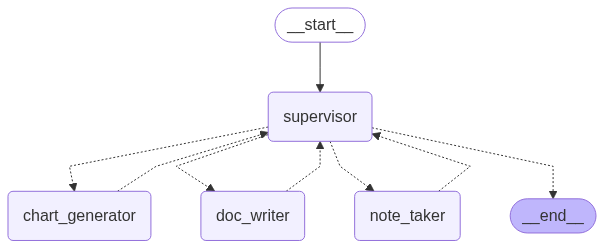

In [32]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [33]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content='I have written the outline and the poem about cats to disk. The files are saved as:\n\n1. **cat_poem_outline.txt** - Contains the outline of the poem.\n2. **cat_poem.txt** - Contains the poem itself.', additional_kwargs={}, response_metadata={}, name='doc_writer', id='d34bbad6-af63-48d1-9095-19412c795215')]}}
---
{'supervisor': {'next': 'note_taker'}}
---
{'note_taker': {'messages': [HumanMessage(content="The outline and the poem about cats have been created. Here are the contents:\n\n### Outline for Poem about Cats (`cat_poem_outline.txt`)\n\n1. Introduction to cats\n2. Whiskers and paws\n3. Curiosity of cats\n4. Feline playfulness\n5. Cats at rest\n6. Conclusion: The charm of cats\n\n### Poem about Cats (`cat_poem.txt`)\n\n```\n# Poem about Cats\n\nIn sunlit patches where shadows play,  \nLies the regal cat, in her own ballet.  \nWith fur like silk and eyes that gleam,  \nShe weaves through 

**Add Layers**

In this design, we are enforcing a top-down planning policy. We've created two graphs already, but we have to decide how to route work between the two.

We'll create a third graph to orchestrate the previous two, and add some connectors to define how this top-level state is shared between the different graphs.

In [44]:
from langchain_core.messages import BaseMessage

In [45]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [46]:
teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [47]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )

In [48]:
def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )

In [49]:
# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

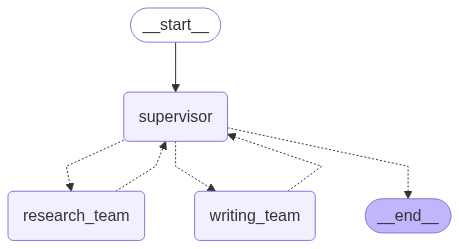

In [50]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [51]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content="### Brief Report on AI Agents\n\n**Introduction**\nAI agents are autonomous software systems designed to perform specific tasks or sets of tasks based on user instructions. Since 2023, they have seen remarkable growth across various industries, including customer service, healthcare, and automation, significantly altering how businesses operate.\n\n**Market Overview**\nThe market for AI agents has expanded rapidly, valued at approximately $3.7 billion in 2023, with projections to reach $150 billion by 2025. This surge is largely driven by advancements in cloud-based AI, Internet of Things (IoT) devices, and automation technologies, making AI agents more accessible and powerful. Major players in the market include IBM's Watson, Amazon's Alexa, and numerous startups focusing on specialized AI services.\n\n**Types of AI Agents**\n1. **Chatbot-like Agents**: These are designed to handle spec

In [52]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "S400 and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content="### Brief Report on the S-400 Missile System\n\nThe **S-400 Triumf** (NATO reporting name: SA-21 Growler) is a sophisticated mobile surface-to-air missile (SAM) system developed by Russia's Almaz Central Design Bureau. It was designed in response to the evolving threats in aerial warfare and the need to counter advanced Western air defense systems like the MIM-104 Patriot.\n\n#### Development and Deployment\n- The S-400 system was approved for service on **April 28, 2007**, and became operational on **August 6, 2007**.\n- It was developed as an upgrade to the earlier S-300 family of missile defense systems, which were created in the late 20th century.\n- The first successful tests were conducted in **1999**, marking the beginning of the system's formal development.\n\n#### Features and Capabilities\n- The S-400 is designed to target not only aircraft but also UAVs and cruise missiles, pr